In [9]:
# Imports
import json
import re
import numpy as np
import numpy.linalg as nplin
import matplotlib.pyplot as plt
import string
import operator
from bs4 import BeautifulSoup
from __future__ import division
from time import time
from operator import itemgetter
%matplotlib inline

# Am I working on AWS?
AWS = False

# Check Spark is working
print sc 

In [151]:
# load data
if AWS:
    rawPNAS = "s3n://stat-37601/pnas.json"
else:
    rawPNAS = "data/pnas.json"

articles = sc.textFile(rawPNAS).map(lambda x: json.loads(x)).cache()

####Define the parser to clean up the text

In [175]:
def parser(article):
    sections = BeautifulSoup(article['body']).find_all(["abs","bdy"]) # grabs the abstract and main body tags
    paragraphs = sum([sec.find_all('p') for sec in sections],[])      # get list of paragraph tags
    text     = ' '.join([par.text for par in paragraphs]).lower()     # get one long string
    text     = re.sub('\s[a-z]\)|\s\([a-z]\)|\s[a-z]\.',' ',text)     # get rid of lists with letters
    text     = re.sub("([a-z])'([a-z])","\g<1>\g<2>",text)            # standardize to no apostroph
    text     = re.sub('[^a-zA-Z0-9\-\s]','',text)                     # keep only alpha numeric, hyphens, and white space
    text     = re.sub('(\s|\A)[0-9\-\s]+(\s|\Z)',' ',text)            # get rid of pure numbers (only want numerics for things like chemical compounds) 
    return text.split()                                               # return a list of words

#### Look at the frequency of words accross corpus

In [180]:
# Get frequencies
wordFreq = articles.flatMap(lambda x: parser(x))\
    .map(lambda x: (str(x),1))\
    .reduceByKey(lambda a,b: a+b)\
    .collect()
    
sortedFreq = sorted([x[1] for x in wordFreq])

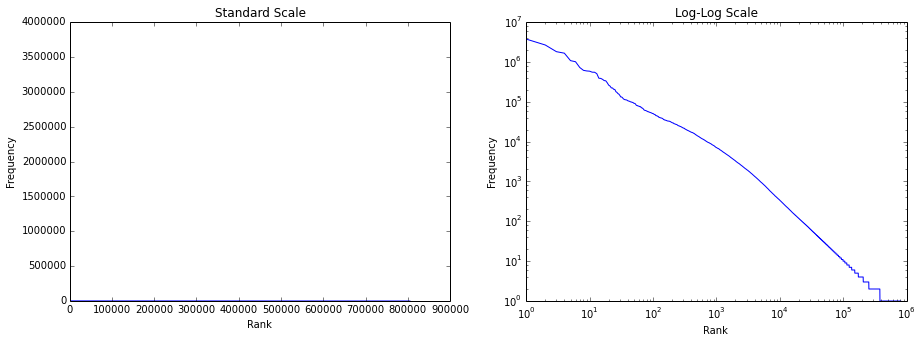

In [193]:
# plot frequency versus rank
rank = np.arange(len(sortedFreq),0,-1)

f,subplts = plt.subplots(1,2)
f.set_size_inches(15,5)
subplts[0].plot(rank,sortedFreq)
subplts[0].set_title("Standard Scale")
subplts[0].set_xlabel("Rank")
subplts[0].set_ylabel("Frequency")
subplts[1].plot(rank,sortedFreq)
subplts[1].set_title("Log-Log Scale")
subplts[1].set_xlabel("Rank")
subplts[1].set_ylabel("Frequency")
subplts[1].set_xscale('log')
subplts[1].set_yscale('log')

We see that Zipf's law pretty much holds. The frequency of words seems to be approximately proportional to the inverse of its rank raised to some power. We see this from the nearly linear negative relationship on the log-log plot between frequency and rank. There relationship isn't perfect (we see small bulges and deviations from the linear fit), but it is reasonably close.

####Get our vocabulary
I exclude the given stop words, some of which were chosen based on appearing in most articles at least once, and then exclude words which don't appear in at least 25 articles.

In [177]:
# List a bunch of commonly used words which we'd like to ignore apriori. A bunch of these were  gotten by looking at words common accross all articles
stop = set(['the', 'and', 'you', 'your', 'for', 'por', 'que', 'las', 'los', 'les',\
       'una', 'del', 'este', 'usted', 'para', 'con', 'this', 'that', 'was', 'have', 'like',\
       'would', 'could', 'should', 'will', 'can', 'shall', 'just', 'all', 'it', 'its', 'per'])
eng_stop = set(['i', 'me', 'my', 'myself', 'we', 'our', \
             'ours', 'ourselves', 'you', 'your', 'yours', \
             'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', \
             'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', \
             'themselves', 'what', 'which', 'who', 'whom', 'this', \
             'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', \
             'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do',\
             'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', \
             'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',\
             'by', 'for', 'with', 'about', 'against', 'between', 'into', \
             'through', 'during', 'before', 'after', \
            'above', 'below', 'to', 'from', 'up', 'down', 'in',\
            'out', 'on', 'off', 'over', 'under', 'again', 'further', \
            'then', 'once', 'here', 'there', 'when', 'where', 'why', \
            'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most',\
            'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', \
            'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', \
            'just', 'don', 'should', 'now','addition', 'also', 'although', \
            'different','either','fig','first','found','however','may',\
            'one','three','thus','two','used','using','well','whereas','whether',\
            'within','therefore'])
letters = set(string.ascii_lowercase)
roman_num = set(['ii','iii','iv','v','vi','vii','viii','ix','x'])
all_stop = stop | eng_stop | letters | roman_num

# get our word list
thresh = 25           # exclude words which appear in fewer articles than this - don't want list to be too long
vocabulary = articles.flatMap(lambda x: list(set(parser(x))))\
    .map(lambda x: (str(x),1))\
    .reduceByKey(lambda a,b: a+b)\
    .filter(lambda x: x[1]>=thresh and not x[1] in all_stop)\
    .collect()
print 'word list includes %d unique words' % len(vocabulary)

word list includes 25243 unique words


In [179]:
# Write the vocabulary to a file
f = open('pnasvocab.txt', 'w')
for w,c in sorted(vocabulary):
    f.write("%s\n" % w)
f.close()